# Customer Churn Prediction Model

This notebook builds a machine learning model to predict customer churn using the Customer Churn Dataset from Kaggle.

## 1. Import Libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Create charts folder if it doesn't exist
Path('charts').mkdir(exist_ok=True)

## 2. Download Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("muhammadshahidazeem/customer-churn-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.66M/6.66M [00:03<00:00, 2.25MB/s]

Extracting files...
Path to dataset files: /Users/ismatsamadov/.cache/kagglehub/datasets/muhammadshahidazeem/customer-churn-dataset/versions/1


## 3. Load Data

In [3]:
# Find the CSV file in the downloaded path
import os
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

# Load the dataset
df = pd.read_csv(os.path.join(path, csv_files[0]))
print(f"\nDataset shape: {df.shape}")
df.head()

Found CSV files: ['customer_churn_dataset-training-master.csv', 'customer_churn_dataset-testing-master.csv']

Dataset shape: (440833, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


## 4. Exploratory Data Analysis

In [4]:
# Basic information
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None

Basic Statistics:


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [5]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing[missing > 0]

Missing Values:


CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [6]:
# Check churn distribution
if 'Churn' in df.columns:
    churn_col = 'Churn'
elif 'churn' in df.columns:
    churn_col = 'churn'
else:
    # Find column that might be churn
    churn_candidates = [col for col in df.columns if 'churn' in col.lower()]
    churn_col = churn_candidates[0] if churn_candidates else df.columns[-1]

print(f"Churn Distribution:")
print(df[churn_col].value_counts())
print(f"\nChurn Rate: {df[churn_col].value_counts(normalize=True).iloc[1]:.2%}")

Churn Distribution:
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

Churn Rate: 43.29%


## 5. Data Visualization

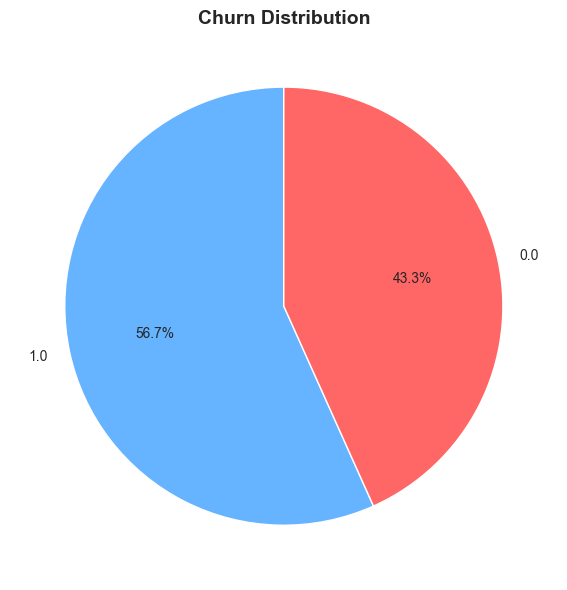

Saved: charts/churn_distribution.png


In [7]:
# Churn distribution pie chart
plt.figure(figsize=(8, 6))
df[churn_col].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.savefig('charts/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/churn_distribution.png")

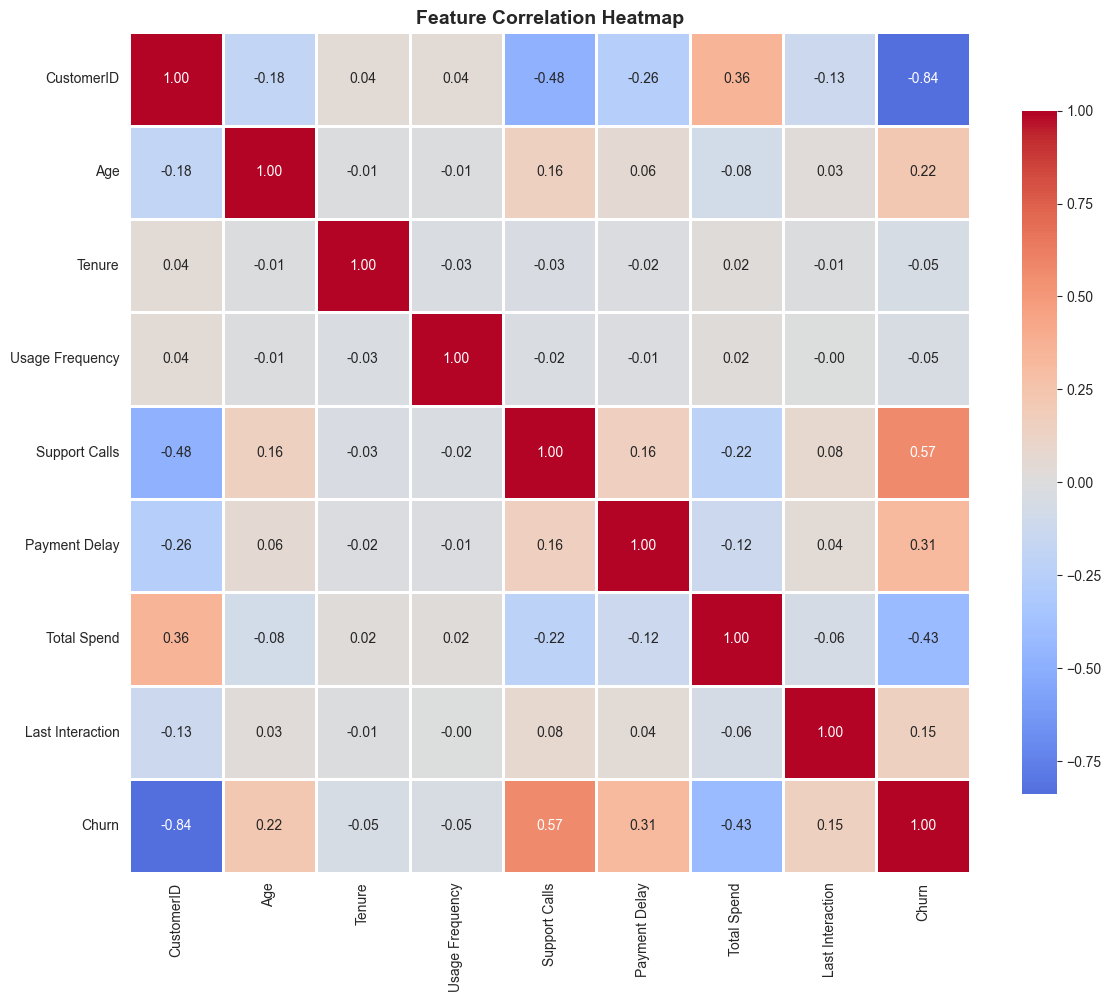

Saved: charts/correlation_heatmap.png


In [8]:
# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('charts/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/correlation_heatmap.png")

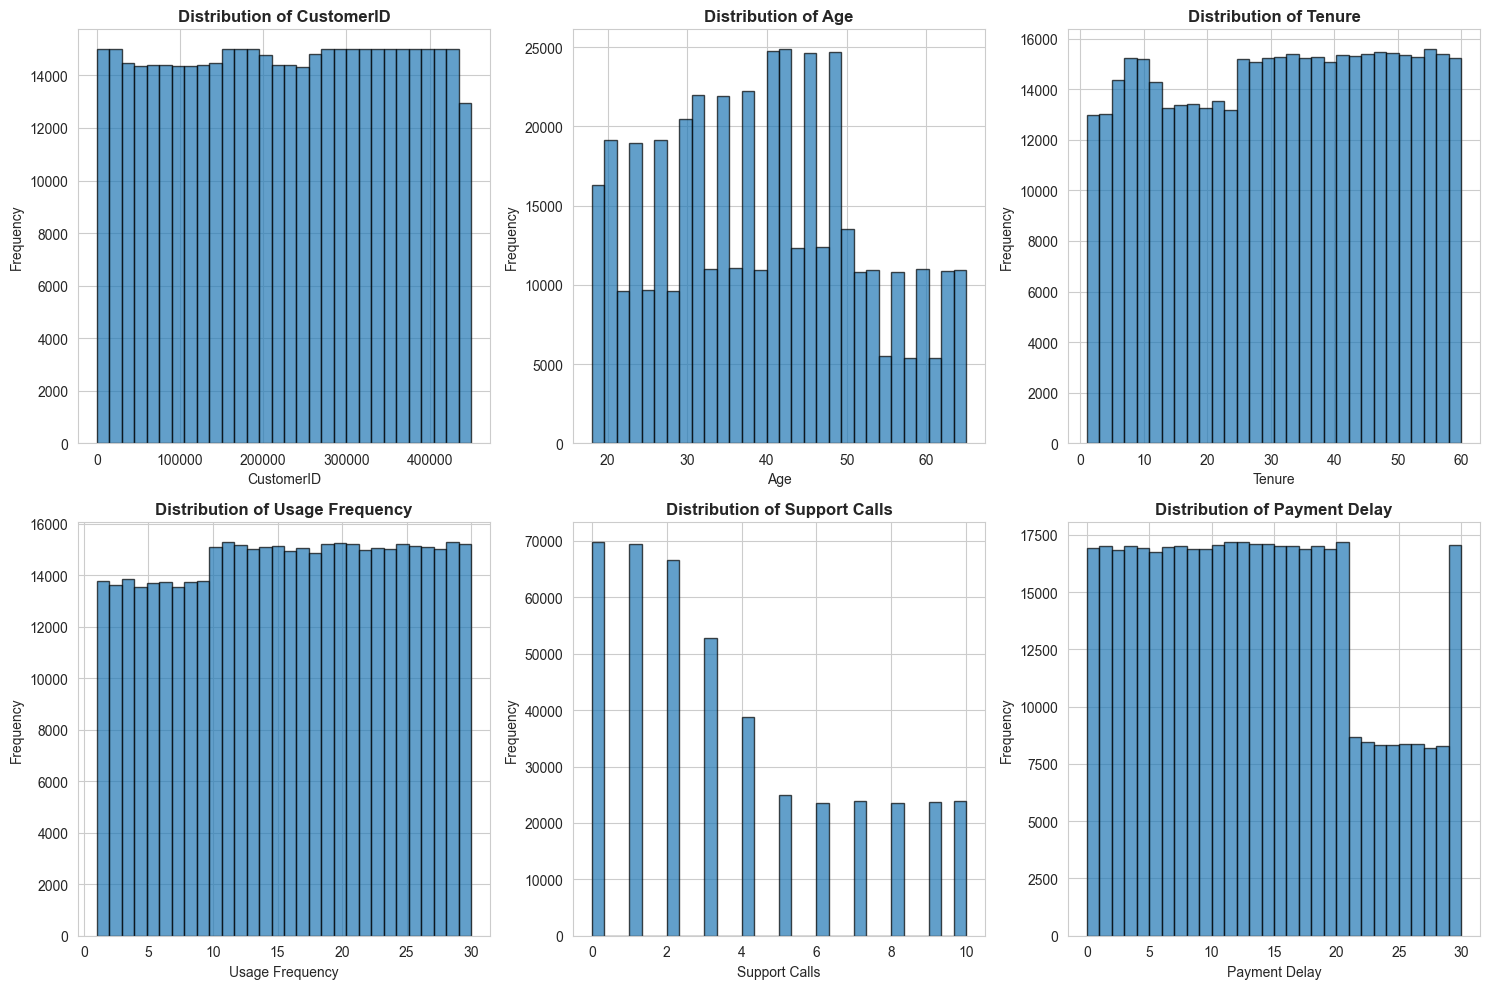

Saved: charts/feature_distributions.png


In [9]:
# Distribution of numerical features
numerical_features = df[numerical_cols].columns.tolist()
if churn_col in numerical_features:
    numerical_features.remove(churn_col)

n_features = min(6, len(numerical_features))  # Show top 6 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_features[:n_features]):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('charts/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/feature_distributions.png")

## 6. Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        if df_processed[col].dtype in ['float64', 'int64']:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

# Encode categorical variables
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != churn_col:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

# Encode target variable
if df_processed[churn_col].dtype == 'object':
    le_target = LabelEncoder()
    df_processed[churn_col] = le_target.fit_transform(df_processed[churn_col])

print(f"Processed dataset shape: {df_processed.shape}")
df_processed.head()

Processed dataset shape: (440833, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,0,39.0,14.0,5.0,18.0,2,0,932.0,17.0,1.0
1,3.0,65.0,0,49.0,1.0,10.0,8.0,0,1,557.0,6.0,1.0
2,4.0,55.0,0,14.0,4.0,6.0,18.0,0,2,185.0,3.0,1.0
3,5.0,58.0,1,38.0,21.0,7.0,7.0,2,1,396.0,29.0,1.0
4,6.0,23.0,1,32.0,20.0,5.0,8.0,0,1,617.0,20.0,1.0


In [11]:
# Split features and target
X = df_processed.drop(churn_col, axis=1)
y = df_processed[churn_col]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 352666
Test set size: 88167


## 7. Model Training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name} - Accuracy: {results[name]['accuracy']:.4f}, "
          f"Precision: {results[name]['precision']:.4f}, "
          f"Recall: {results[name]['recall']:.4f}, "
          f"F1: {results[name]['f1']:.4f}, "
          f"ROC AUC: {results[name]['roc_auc']:.4f}")


Training Logistic Regression...
Logistic Regression - Accuracy: 0.9780, Precision: 0.9812, Recall: 0.9800, F1: 0.9806, ROC AUC: 0.9943

Training Random Forest...
Random Forest - Accuracy: 0.9996, Precision: 0.9995, Recall: 0.9999, F1: 0.9997, ROC AUC: 1.0000

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9978, Precision: 0.9968, Recall: 0.9993, F1: 0.9981, ROC AUC: 1.0000


## 8. Model Evaluation and Visualization


Model Performance Comparison:
              Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression  0.977985   0.981158 0.98000  0.980579 0.994329
      Random Forest  0.999648   0.999500 0.99988  0.999690 0.999999
  Gradient Boosting  0.997811   0.996848 0.99930  0.998072 0.999981


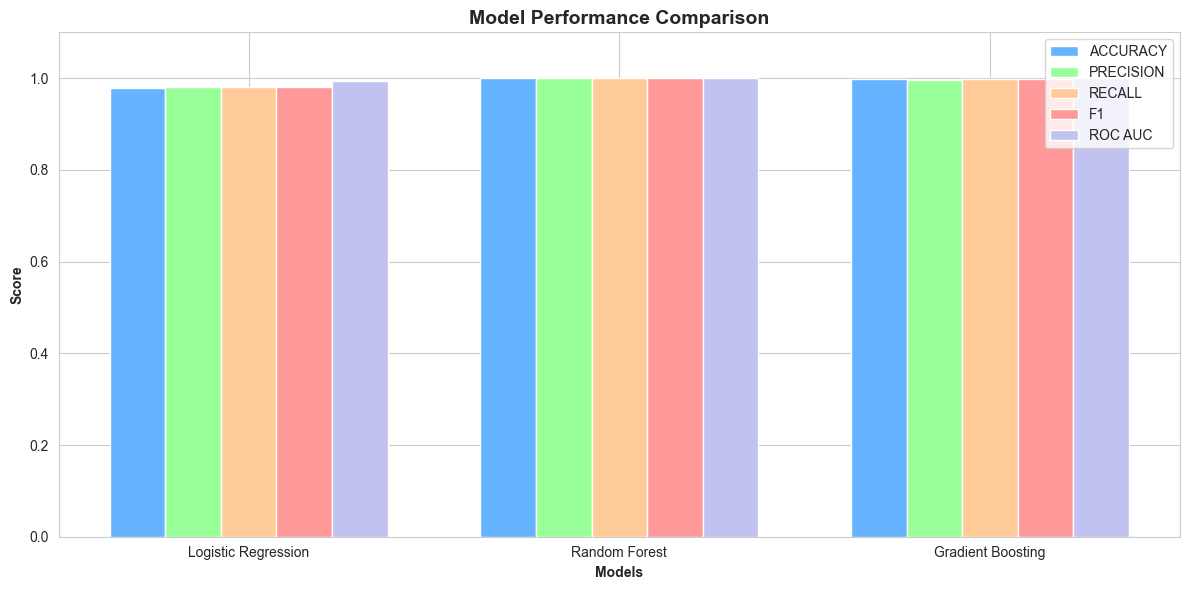

Saved: charts/model_comparison.png


In [13]:
# Compare model performance
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1 Score': [results[m]['f1'] for m in results.keys()],
    'ROC AUC': [results[m]['roc_auc'] for m in results.keys()]
})

print("\nModel Performance Comparison:")
print(metrics_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.15

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999', '#c2c2f0']

for i, metric in enumerate(metrics):
    values = [results[m][metric] for m in results.keys()]
    ax.bar(x + i*width, values, width, label=metric.upper().replace('_', ' '), color=colors[i])

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results.keys())
ax.legend()
ax.set_ylim([0, 1.1])
plt.tight_layout()
plt.savefig('charts/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/model_comparison.png")

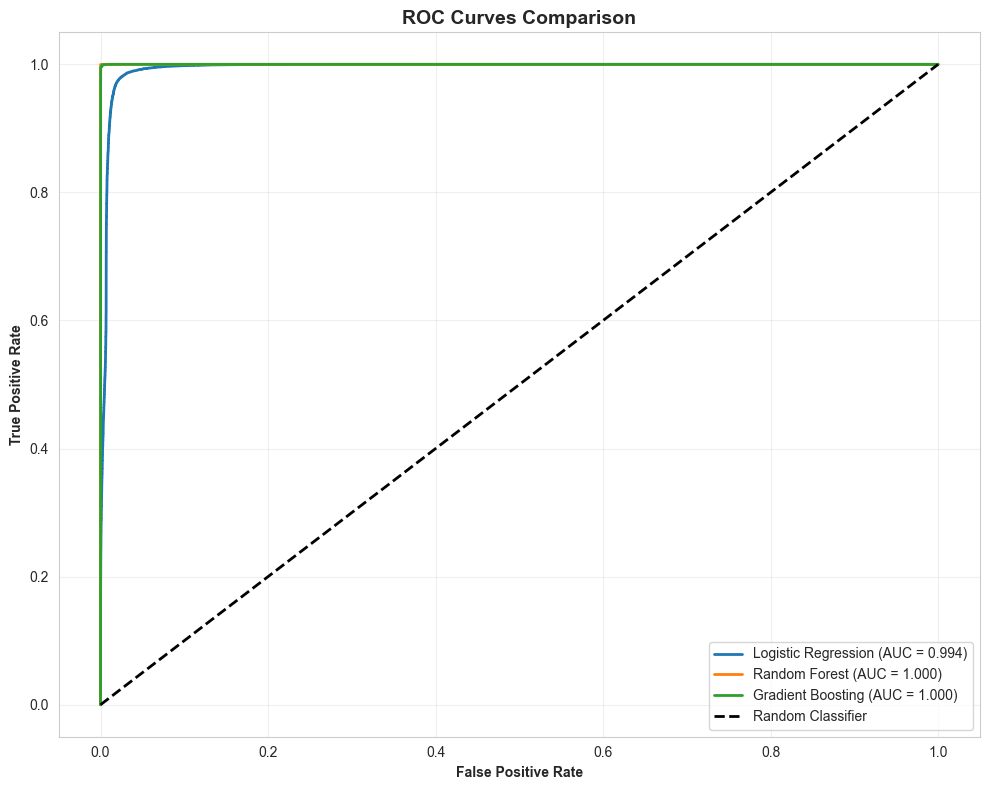

Saved: charts/roc_curves.png


In [14]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['roc_auc']:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves Comparison', fontweight='bold', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/roc_curves.png")


Best Model: Random Forest
F1 Score: 0.9997


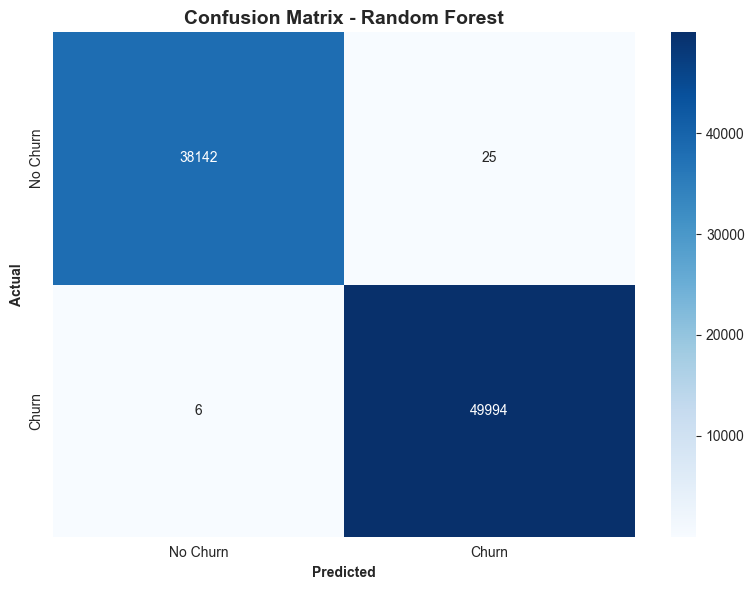

Saved: charts/confusion_matrix.png

Classification Report - Random Forest:
              precision    recall  f1-score   support

    No Churn       1.00      1.00      1.00     38167
       Churn       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



In [15]:
# Find best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"F1 Score: {results[best_model_name]['f1']:.4f}")

# Confusion matrix for best model
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.savefig('charts/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: charts/confusion_matrix.png")

# Classification report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, results[best_model_name]['y_pred'], 
                          target_names=['No Churn', 'Churn']))

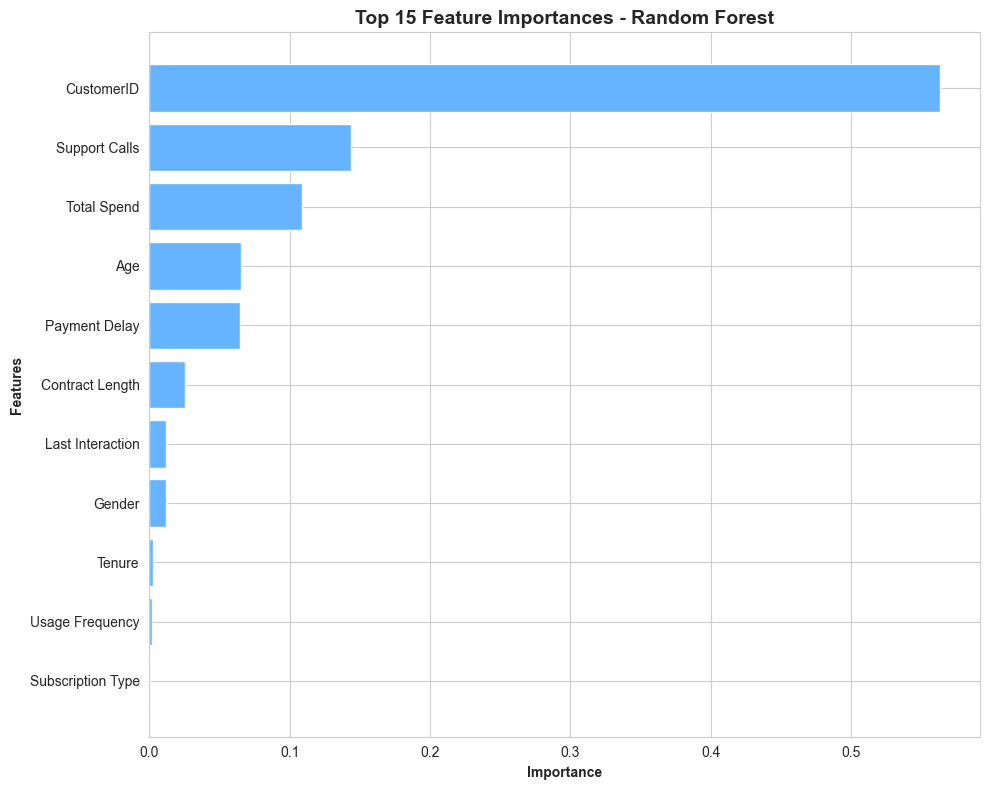

Saved: charts/feature_importance.png

Top 10 Most Important Features:
         feature  importance
      CustomerID    0.563713
   Support Calls    0.143883
     Total Spend    0.108664
             Age    0.064985
   Payment Delay    0.064865
 Contract Length    0.025616
Last Interaction    0.011880
          Gender    0.011761
          Tenure    0.002675
 Usage Frequency    0.001528


In [16]:
# Feature importance for tree-based models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='#66b3ff')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.ylabel('Features', fontweight='bold')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('charts/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: charts/feature_importance.png")
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

## 9. Save Model

In [17]:
import pickle

# Save the best model
model_data = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name
}

with open('best_churn_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"Best model ({best_model_name}) saved to: best_churn_model.pkl")

Best model (Random Forest) saved to: best_churn_model.pkl


## 10. Summary

In [18]:
print("="*60)
print("CHURN PREDICTION MODEL SUMMARY")
print("="*60)
print(f"\nDataset: Customer Churn Dataset")
print(f"Total Records: {len(df)}")
print(f"Features: {X.shape[1]}")
print(f"Training Set: {len(X_train)} samples")
print(f"Test Set: {len(X_test)} samples")
print(f"\nBest Model: {best_model_name}")
print(f"  - Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"  - Precision: {results[best_model_name]['precision']:.4f}")
print(f"  - Recall:    {results[best_model_name]['recall']:.4f}")
print(f"  - F1 Score:  {results[best_model_name]['f1']:.4f}")
print(f"  - ROC AUC:   {results[best_model_name]['roc_auc']:.4f}")
print(f"\nCharts saved in: charts/")
print(f"Model saved as: best_churn_model.pkl")
print("="*60)

CHURN PREDICTION MODEL SUMMARY

Dataset: Customer Churn Dataset
Total Records: 440833
Features: 11
Training Set: 352666 samples
Test Set: 88167 samples

Best Model: Random Forest
  - Accuracy:  0.9996
  - Precision: 0.9995
  - Recall:    0.9999
  - F1 Score:  0.9997
  - ROC AUC:   1.0000

Charts saved in: charts/
Model saved as: best_churn_model.pkl
